In [90]:
# !pip install pydicom
# !pip install pylibjpeg
# !pip install torchinfo

In [110]:
from torch.utils.data import Dataset, DataLoader
import os
import pydicom
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image

import pylibjpeg

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations/labels.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return self.image_labels.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # read image file from directory
        image_name = os.path.join(self.root_dir,
                                    f'{self.image_labels.iloc[idx, 0]}.png')
        image_file = Image.open(image_name)
        # convert image to grayscale and convert to numpy, then apply transforms
        image_file = np.array(image_file).astype(np.uint8)

        # display image file
        plt.imshow(image_file, cmap='gray')
        plt.show()

        image = image_file
        

        # # plt.imshow(image_file.pixel_array, cmap=plt.cm.bone)
        # image = image_file.pixel_array
        # image = image / 4096                           # scaling from 0 to 1 range
        # image = (image * 256 // 1).astype(np.uint8)    # converting to uint8 and scaling to 0-255
        # label = self.image_labels.iloc[idx, 2:].astype(float)
        # label = torch.from_numpy(np.array(label))
        if self.transform:
            image = self.transform(image)
        # print(image.shape, label.shape)
        # print(type(image), type(label))
        return image, label
        



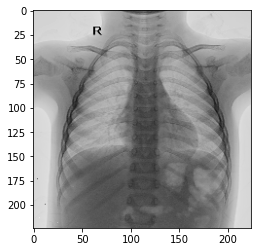

torch.Size([1, 1, 224, 224]) torch.Size([1, 15])


In [111]:
test_transforms = transforms.Compose([ transforms.ToPILImage(), transforms.Resize(size=(224, 224)), transforms.ToTensor() ])
# test_transforms = transforms.Compose([ transforms.ToTensor() ])
# test_transforms=None
# test_transforms = transforms.Compose([ transforms.Resize(size=(224, 224)) ])


train_labels_path = r"image_labels_train.csv"
train_images_path = r"train_png"
train_ds = FaceLandmarksDataset(train_labels_path, train_images_path, transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_ds,
                                            batch_size=1, shuffle=True)

for images, labels in train_loader:
    print(images.shape, labels.shape)
    for image, label in zip(images, labels):
        img = transforms.ToPILImage()(image)
        # img.show()
    break

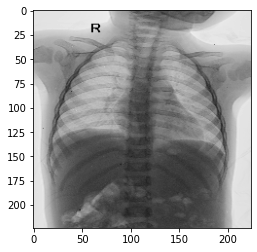

torch.Size([1, 1, 224, 224]) torch.Size([1, 15])


In [112]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    for image, label in zip(images, labels):
        img = transforms.ToPILImage()(image) #
        img.show()
    break

# MAIN

In [98]:
input_dims = 224, 224
num_channels = 1
learning_rate = 1e-3
n_epochs = 2
batch_size = 32

num_classes = 15

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

## defining dataloaders

In [101]:
test_transforms = transforms.Compose([ transforms.ToPILImage(), transforms.Resize(size=(224, 224)), transforms.ToTensor() ])


train_labels_path = r"image_labels_train.csv"
train_images_path = r"train"
train_ds = FaceLandmarksDataset(train_labels_path, train_images_path, transform=test_transforms)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

test_labels_path = r"image_labels_test.csv"
test_images_path = r"test"
test_ds = FaceLandmarksDataset(test_labels_path, test_images_path, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True)


## Defining model class

In [102]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=num_channels, out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32,           out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32,           out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2),

            torch.nn.Conv2d(in_channels=32,           out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64,           out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64,           out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2),

            torch.nn.Conv2d(in_channels=64,           out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2),

            torch.nn.Conv2d(in_channels=128,           out_channels=256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2),
            
            torch.nn.Conv2d(in_channels=256,           out_channels=512, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2),

            # fully connected layers
            torch.nn.Flatten(),
            torch.nn.Linear(7*7*512, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, num_classes),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = CNN().to(device)

from torchinfo import summary
summary(model, input_size=(batch_size, 1, *input_dims))



Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      --                        --
├─Sequential: 1-1                        [32, 15]                  --
│    └─Conv2d: 2-1                       [32, 32, 224, 224]        320
│    └─ReLU: 2-2                         [32, 32, 224, 224]        --
│    └─Conv2d: 2-3                       [32, 32, 224, 224]        9,248
│    └─ReLU: 2-4                         [32, 32, 224, 224]        --
│    └─Conv2d: 2-5                       [32, 32, 224, 224]        9,248
│    └─ReLU: 2-6                         [32, 32, 224, 224]        --
│    └─AvgPool2d: 2-7                    [32, 32, 112, 112]        --
│    └─Conv2d: 2-8                       [32, 64, 112, 112]        18,496
│    └─ReLU: 2-9                         [32, 64, 112, 112]        --
│    └─Conv2d: 2-10                      [32, 64, 112, 112]        36,928
│    └─ReLU: 2-11                        [32, 64, 112, 112]        --


In [103]:
for images, labels in train_loader:
    # print shape of outputs of model on this batch
    print(model(images).shape)
    break

torch.Size([32, 15])
